In [4]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [5]:
print("Tensorflow-version:", tensorflow.__version__)


Tensorflow-version: 2.6.0


In [6]:
model_d=MobileNet(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(6,activation='softmax')(x) #FC-layer

17235968/17225924 [==============================] - 0s 0us/step


In [7]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

In [8]:
for layer in model.layers[:-8]:
   layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("../content/gdrive/MyDrive/Studio 3A/AustralianSnake/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("../content/gdrive/MyDrive/Studio 3A/AustralianSnake/"+img)))
    for i in path:
        image = cv2.imread("../content/gdrive/MyDrive/Studio 3A/AustralianSnake/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['NotechisScutatus', 'DendrelaphisPunctulatus', 'MoreliaSpilota', 'PseudechisPorphyriacus', 'BoigaIrregularis', 'PseudonajaTextilis']


In [12]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [13]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(2300, 128, 128, 3) (575, 128, 128, 3)


In [14]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('../content/gdrive/MyDrive/Studio 3A/model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/50
17/17 - 58s - loss: 2.3329 - accuracy: 0.3264 - val_loss: 1.3392 - val_accuracy: 0.4874

Epoch 00001: val_loss improved from inf to 1.33925, saving model to ../content/gdrive/MyDrive/Studio 3A/model.h5
Epoch 2/50
17/17 - 55s - loss: 1.8036 - accuracy: 0.4458 - val_loss: 1.1613 - val_accuracy: 0.5704

Epoch 00002: val_loss improved from 1.33925 to 1.16127, saving model to ../content/gdrive/MyDrive/Studio 3A/model.h5
Epoch 3/50
17/17 - 55s - loss: 1.6155 - accuracy: 0.4793 - val_loss: 0.9876 - val_accuracy: 0.6326

Epoch 00003: val_loss improved from 1.16127 to 0.98764, saving model to ../content/gdrive/MyDrive/Studio 3A/model.h5
Epoch 4/50
17/17 - 55s - loss: 1.3884 - accuracy: 0.5193 - val_loss: 0.8953 - val_accuracy: 0.6652

Epoch 00004: val_loss improved from 0.98764 to 0.89535, saving model to ../content/gdrive/MyDrive/Studio 3A/model.h5
Epoch 5/50
17/17 - 55s - loss: 1.3309 - accuracy: 0.5401 - val_loss: 0.8508 - val_accuracy: 0.6835

Epoch 00005: val_loss improved from 

In [15]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 575 	accurately-predicted-data: 316 	 wrongly-predicted-data:  259
Accuracy: 54.957 %


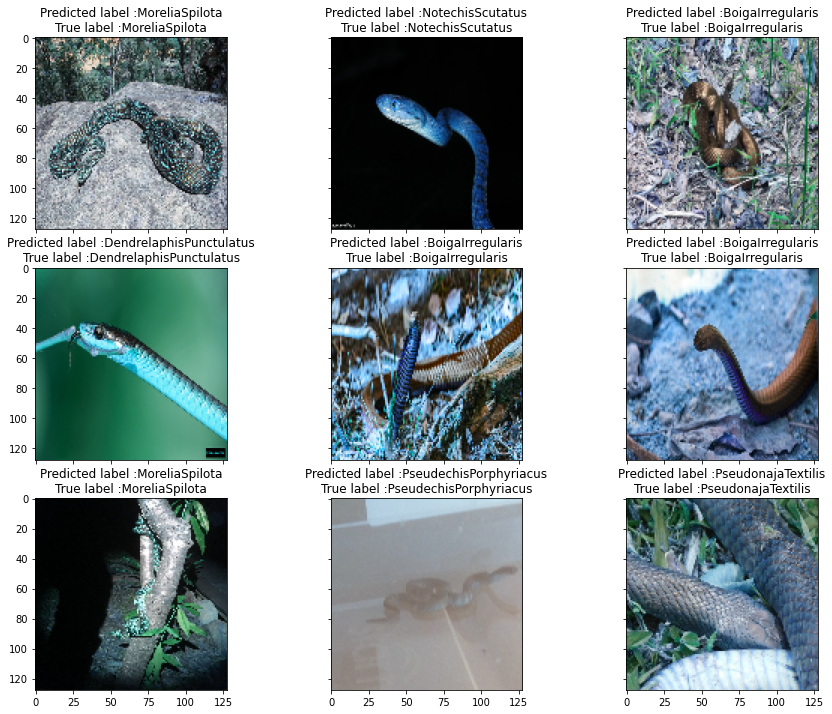

In [16]:
label=['NotechisScutatus', 'DendrelaphisPunctulatus', 'MoreliaSpilota', 'PseudechisPorphyriacus', 'BoigaIrregularis', 'PseudonajaTextilis']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

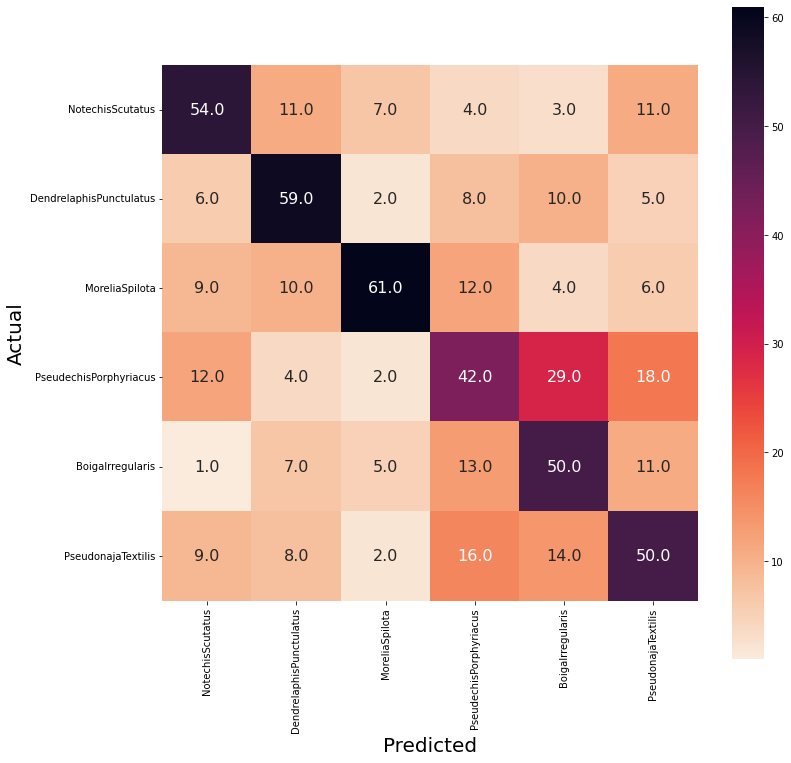

In [17]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)